In [1]:
from pathlib import Path

import pandas as pd
import regex as re
from IPython.core.display_functions import display

In [2]:
data_dir = "./exp-local/data"


def import_data(dir):
    all_files = Path(dir).glob('data*.txt')
    all_data = [pd.read_fwf(path, skiprows=[1], index_col=None) for path in all_files]
    return pd.concat(all_data, axis=0, ignore_index=True)


data = import_data(data_dir)
data

,JobID,JobName,Cluster,Unnamed: 3,NodeList,State,Start,End,ConsumedEnergy,AveRSS,...,WCKey,WCKeyID,WorkDir,Submit,Unnamed: 112,Unnamed: 113,Unnamed: 114,SubmitLine,Unnamed: 110,Unnamed: 111
0,49404,dpp-local-nc8_gl5-37.cfg,gl2_gl4,NaN,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,sbatch --job-name=dpp-local-nc8_gl5-37.cfg -w ...,&& perf stat,"-e power/energy-pkg/,power/energy-ram/ haddock...",> run.dpp-local-nc8_gl5-37.cfg.info/haddock.ou...,NaN,NaN
1,49404.batch,batch,gl2_gl4,NaN,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,283.30K,1184184K,...,NaN,NaN,NaN,2024-01-19T18:08:03,NaN,NaN,NaN,NaN,NaN,NaN
2,49407,daa-local-nc8_gl5-38.cfg,gl2_gl4,NaN,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,sbatch --job-name=daa-local-nc8_gl5-38.cfg -w ...,&& perf stat,"-e power/energy-pkg/,power/energy-ram/ haddock...",> run.daa-local-nc8_gl5-38.cfg.info/haddock.ou...,NaN,NaN
3,49407.batch,batch,gl2_gl4,NaN,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4.20M,2618236K,...,NaN,NaN,NaN,2024-01-19T18:56:40,NaN,NaN,NaN,NaN,NaN,NaN
4,49410,dpp-local-nc4_gl5-36.cfg,gl2_gl4,NaN,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,sbatch --job-name=dpp-local-nc4_gl5-36.cfg -w ...,&& perf stat,"-e power/energy-pkg/,power/energy-ram/ haddock...",> run.dpp-local-nc4_gl5-36.cfg.info/haddock.ou...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,49677.batch,batch,gl2_gl4,NaN,superserver2,COMPLETED,2024-01-28T19:03:42,2024-01-28T20:16:32,NaN,646812K,...,NaN,NaN,NaN,2024-01-28T19:03:42,NaN,NaN,NaN,NaN,NaN,NaN
314,49680,dpp-local-nc32_ss2-7.cfg,gl2_gl4,NaN,superserver2,COMPLETED,2024-01-28T20:21:36,2024-01-28T20:42:40,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:20,"power/energy-pkg/,power/energy-ram/ haddock3 '...",NaN,NaN,run.dpp-local-nc32_ss2-7.cfg.info/haddock.outp...,sbatch --job-name=dpp-local-nc32_ss2-7.cfg -w ...,perf stat -e
315,49680.batch,batch,gl2_gl4,NaN,superserver2,COMPLETED,2024-01-28T20:21:36,2024-01-28T20:42:40,NaN,3876116K,...,NaN,NaN,NaN,2024-01-28T20:21:36,NaN,NaN,NaN,NaN,NaN,NaN
316,49584,daa-local-nc4_ss2-1.cfg,gl2_gl4,NaN,superserver2,FAILED,2024-01-22T13:43:33,2024-01-22T13:43:35,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-22T13:41:10,"-e power/energy-pkg/,power/energy-ram/ haddock...",NaN,NaN,> run.daa-local-nc4_ss2-1.cfg.info/haddock.out...,sbatch --job-name=daa-local-nc4_ss2-1.cfg -w s...,&& perf stat


In [3]:
def convert_to_numeric(value):
    match = re.match(r'^([\d.]+)([KkMm])$', value)
    if match:
        numeric_part = float(match.group(1))
        multiplier = match.group(2).upper()

        if multiplier == 'K':
            return numeric_part * 1000
        elif multiplier == 'M':
            return numeric_part * 1000000

    return value


def convert_elapsed_time(elapsed_time):
    parts = elapsed_time.split('-') if '-' in elapsed_time else [0, elapsed_time]
    days = int(parts[0])
    time_parts = parts[1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
    return total_seconds

In [4]:
def filter_out_completed_jobs(dat):
    dat = dat[dat.State == 'COMPLETED']
    dat.JobName = dat.JobName.replace('batch', method='ffill')
    return dat.dropna(subset=['ConsumedEnergy'])


def extract_params_from_local_file_name(dat):
    dat[['Workflow', 'mode', 'ncores', 'node', 'trial']] = dat.JobName.str.extract(
        r'(\w+)-(\w+)-nc(\d+)_(\w+?\d+)-(\d+).cfg')
    dat.ncores = dat.ncores.astype(int)
    dat.trial = dat.trial.astype(int)
    return dat


def append_job_data_columns(dat):
    for column in ['ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']:
        dat[column] = dat[column].apply(convert_to_numeric)
        dat[f"{column}K"] = dat[column] / 1000
        dat[f"{column}M"] = dat[column] / 1_000_000
        dat[f"{column}G"] = dat[column] / 1_000_000_000
    dat['ElapsedSeconds'] = dat.Elapsed.apply(convert_elapsed_time)
    dat['ElapsedMinutes'] = dat.ElapsedSeconds / 60
    dat['ElapsedHours'] = dat.ElapsedMinutes / 60
    return dat


In [5]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]

data_completed = filter_out_completed_jobs(data)
data_completed = data_completed[~data_completed.JobName.str.contains("nc2")].reset_index(drop=True)

data_pending = data[data.State == "PENDING"]
data_pending = data_pending[~data_pending.JobName.str.contains("nc2")].reset_index(drop=True)

data = pd.concat([data_completed, data_pending], axis=0, ignore_index=True)
# data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)

data = extract_params_from_local_file_name(data)
data_completed = extract_params_from_local_file_name(data_completed)
data_pending = extract_params_from_local_file_name(data_pending)

data_completed = append_job_data_columns(data_completed)
data_completed = data_completed.sort_values(by=['ncores', 'Workflow'])

display(data_completed, data_pending, data)

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_27380\1217720985.py:3: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  dat.JobName = dat.JobName.replace('batch', method='ffill')
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_27380\1217720985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.JobName = dat.JobName.replace('batch', method='ffill')


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskReadG,AveDiskWriteK,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours
3,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6810000.0,1.458672e+09,8.835429e+10,...,88.35429,12747730.0,12747.73,12.74773,27547032.0,27547.032,27.547032,65071,1084.516667,18.075278
5,49419.batch,daa-local-nc4_gl5-35.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T01:36:44,2024-01-21T19:33:26,6770000.0,1.480084e+09,8.835445e+10,...,88.35445,12748270.0,12748.27,12.74827,27545968.0,27545.968,27.545968,64602,1076.700000,17.945000
11,49452.batch,daa-local-nc4_gl5-33.cfg,gl2_gl4,gl5,COMPLETED,2024-01-22T16:44:12,2024-01-23T11:56:14,7090000.0,1.456736e+09,8.837870e+10,...,88.37870,12751520.0,12751.52,12.75152,27541820.0,27541.820,27.541820,69122,1152.033333,19.200556
24,49494.batch,daa-local-nc4_gl5-31.cfg,gl2_gl4,gl5,COMPLETED,2024-01-25T07:19:44,2024-01-26T01:30:06,6840000.0,1.473504e+09,8.837870e+10,...,88.37870,12751550.0,12751.55,12.75155,27541824.0,27541.824,27.541824,65422,1090.366667,18.172778
34,49524.batch,daa-local-nc4_gl5-34.cfg,gl2_gl4,gl5,COMPLETED,2024-01-26T17:45:03,2024-01-27T11:59:53,6830000.0,1.457012e+09,8.835429e+10,...,88.35429,12747490.0,12747.49,12.74749,27545764.0,27545.764,27.545764,65690,1094.833333,18.247222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,48951.batch,dpp-local-nc32_gl6-39.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T14:30:43,2024-01-18T14:51:47,197850.0,3.898280e+09,5.341970e+09,...,5.34197,804560.0,804.56,0.80456,193745988.0,193745.988,193.745988,1264,21.066667,0.351111
57,48969.batch,dpp-local-nc32_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-19T06:29:36,2024-01-19T06:50:34,195380.0,3.915472e+09,5.341970e+09,...,5.34197,804930.0,804.93,0.80493,193754312.0,193754.312,193.754312,1258,20.966667,0.349444
62,48984.batch,dpp-local-nc32_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T19:38:30,2024-01-20T20:02:07,203200.0,3.947376e+09,5.345290e+09,...,5.34529,805130.0,805.13,0.80513,193741932.0,193741.932,193.741932,1417,23.616667,0.393611
63,48990.batch,dpp-local-nc32_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T20:12:15,2024-01-20T20:34:20,198180.0,3.915520e+09,5.345290e+09,...,5.34529,805130.0,805.13,0.80513,193750256.0,193750.256,193.750256,1325,22.083333,0.368056


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,WCKey,WCKeyID,WorkDir,Submit,SubmitLine,Workflow,mode,ncores,node,trial
0,49431,daa-local-nc4_gl5-38.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,> run.daa-local-nc4_gl5-38.cfg.info/haddock.ou...,daa,local,4,gl5,38
1,49434,daa-local-nc8_gl5-33.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,> run.daa-local-nc8_gl5-33.cfg.info/haddock.ou...,daa,local,8,gl5,33
2,49041,daa-local-nc16_gl6-38.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:58,run.daa-local-nc16_gl6-38.cfg.info/haddock.out...,daa,local,16,gl6,38
3,49044,daa-local-nc32_gl6-37.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:58,run.daa-local-nc32_gl6-37.cfg.info/haddock.out...,daa,local,32,gl6,37
4,49053,daa-local-nc16_gl6-31.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:58,run.daa-local-nc16_gl6-31.cfg.info/haddock.out...,daa,local,16,gl6,31
5,49056,daa-local-nc32_gl6-33.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:58,run.daa-local-nc32_gl6-33.cfg.info/haddock.out...,daa,local,32,gl6,33
6,49059,dpp-local-nc32_gl6-35.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:58,run.dpp-local-nc32_gl6-35.cfg.info/haddock.out...,dpp,local,32,gl6,35
7,49062,daa-local-nc8_gl6-39.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:58,> run.daa-local-nc8_gl6-39.cfg.info/haddock.ou...,daa,local,8,gl6,39
8,49065,daa-local-nc16_gl6-37.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:58,run.daa-local-nc16_gl6-37.cfg.info/haddock.out...,daa,local,16,gl6,37
9,49068,dpp-local-nc4_gl6-34.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:58,> run.dpp-local-nc4_gl6-34.cfg.info/haddock.ou...,dpp,local,4,gl6,34


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,WCKey,WCKeyID,WorkDir,Submit,SubmitLine,Workflow,mode,ncores,node,trial
0,49404.batch,dpp-local-nc8_gl5-37.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,283.30K,1184184K,5342.08M,...,NaN,NaN,NaN,2024-01-19T18:08:03,NaN,dpp,local,8,gl5,37
1,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4.20M,2618236K,88378.70M,...,NaN,NaN,NaN,2024-01-19T18:56:40,NaN,daa,local,8,gl5,38
2,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449.46K,693064K,5345.29M,...,NaN,NaN,NaN,2024-01-20T05:18:16,NaN,dpp,local,4,gl5,36
3,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6.81M,1458672K,88354.29M,...,NaN,NaN,NaN,2024-01-20T06:39:24,NaN,daa,local,4,gl5,32
4,49416.batch,dpp-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T00:48:59,2024-01-21T01:31:40,281.23K,1204728K,5345.28M,...,NaN,NaN,NaN,2024-01-21T00:48:59,NaN,dpp,local,8,gl5,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,49125,dpp-local-nc8_gl6-40.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:59,> run.dpp-local-nc8_gl6-40.cfg.info/haddock.ou...,dpp,local,8,gl6,40
116,49128,dpp-local-nc8_gl6-37.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:59,> run.dpp-local-nc8_gl6-37.cfg.info/haddock.ou...,dpp,local,8,gl6,37
117,49050,daa-local-nc32_gl6-32.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-22T13:51:12,run.daa-local-nc32_gl6-32.cfg.info/haddock.out...,daa,local,32,gl6,32
118,49578,dpp-local-nc32_ss2-1.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0.0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-20T12:40:19,run.dpp-local-nc32_ss2-1.cfg.info/haddock.outp...,dpp,local,32,ss2,1


In [6]:
data = data.dropna(subset=['AveCPU'])

data['n_ave_cpu'] = data['AveCPU'].apply(convert_elapsed_time)
data['n_elapsed'] = data['Elapsed'].apply(convert_elapsed_time)
data['cpu_utilization'] = data['n_ave_cpu'] / data['n_elapsed']

data_completed = data_completed.dropna(subset=['AveCPU'])
data_completed['n_ave_cpu'] = data_completed['AveCPU'].apply(convert_elapsed_time)
data_completed['n_elapsed'] = data_completed['Elapsed'].apply(convert_elapsed_time)
data_completed['cpu_utilization'] = data_completed['n_ave_cpu'] / data_completed['n_elapsed']

display(data, data_completed)

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,Submit,SubmitLine,Workflow,mode,ncores,node,trial,n_ave_cpu,n_elapsed,cpu_utilization
0,49404.batch,dpp-local-nc8_gl5-37.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,283.30K,1184184K,5342.08M,...,2024-01-19T18:08:03,NaN,dpp,local,8,gl5,37,17247,2613,6.600459
1,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4.20M,2618236K,88378.70M,...,2024-01-19T18:56:40,NaN,daa,local,8,gl5,38,252844,36993,6.834915
2,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449.46K,693064K,5345.29M,...,2024-01-20T05:18:16,NaN,dpp,local,4,gl5,36,15875,4564,3.478309
3,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6.81M,1458672K,88354.29M,...,2024-01-20T06:39:24,NaN,daa,local,4,gl5,32,225582,65071,3.466706
4,49416.batch,dpp-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T00:48:59,2024-01-21T01:31:40,281.23K,1204728K,5345.28M,...,2024-01-21T00:48:59,NaN,dpp,local,8,gl5,38,17227,2561,6.726669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,49176.batch,daa-local-nc8_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-25T23:20:26,2024-01-26T09:13:57,4.75M,2615932K,88378.71M,...,2024-01-25T23:20:26,NaN,daa,local,8,gl6,33,249607,35611,7.009267
83,49179.batch,daa-local-nc4_gl6-31.cfg,gl2_gl4,gl6,COMPLETED,2024-01-26T09:19:01,2024-01-27T02:42:47,7.63M,1461540K,88378.70M,...,2024-01-26T09:19:01,NaN,daa,local,4,gl6,31,223587,62626,3.570194
84,49185.batch,daa-local-nc16_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-27T02:52:55,2024-01-27T08:52:35,3.22M,4929936K,88354.49M,...,2024-01-27T02:52:55,NaN,daa,local,16,gl6,32,287881,21580,13.340176
85,49188.batch,daa-local-nc4_gl6-37.cfg,gl2_gl4,gl6,COMPLETED,2024-01-27T08:57:39,2024-01-28T02:22:29,7.65M,1702840K,88378.70M,...,2024-01-27T08:57:39,NaN,daa,local,4,gl6,37,223541,62690,3.565816


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours,n_ave_cpu,n_elapsed,cpu_utilization
3,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6810000.0,1.458672e+09,8.835429e+10,...,12.74773,27547032.0,27547.032,27.547032,65071,1084.516667,18.075278,225582,65071,3.466706
5,49419.batch,daa-local-nc4_gl5-35.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T01:36:44,2024-01-21T19:33:26,6770000.0,1.480084e+09,8.835445e+10,...,12.74827,27545968.0,27545.968,27.545968,64602,1076.700000,17.945000,224956,64602,3.482183
11,49452.batch,daa-local-nc4_gl5-33.cfg,gl2_gl4,gl5,COMPLETED,2024-01-22T16:44:12,2024-01-23T11:56:14,7090000.0,1.456736e+09,8.837870e+10,...,12.75152,27541820.0,27541.820,27.541820,69122,1152.033333,19.200556,226267,69122,3.273444
24,49494.batch,daa-local-nc4_gl5-31.cfg,gl2_gl4,gl5,COMPLETED,2024-01-25T07:19:44,2024-01-26T01:30:06,6840000.0,1.473504e+09,8.837870e+10,...,12.75155,27541824.0,27541.824,27.541824,65422,1090.366667,18.172778,225263,65422,3.443230
34,49524.batch,daa-local-nc4_gl5-34.cfg,gl2_gl4,gl5,COMPLETED,2024-01-26T17:45:03,2024-01-27T11:59:53,6830000.0,1.457012e+09,8.835429e+10,...,12.74749,27545764.0,27545.764,27.545764,65690,1094.833333,18.247222,225808,65690,3.437479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,48951.batch,dpp-local-nc32_gl6-39.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T14:30:43,2024-01-18T14:51:47,197850.0,3.898280e+09,5.341970e+09,...,0.80456,193745988.0,193745.988,193.745988,1264,21.066667,0.351111,28686,1264,22.694620
57,48969.batch,dpp-local-nc32_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-19T06:29:36,2024-01-19T06:50:34,195380.0,3.915472e+09,5.341970e+09,...,0.80493,193754312.0,193754.312,193.754312,1258,20.966667,0.349444,28256,1258,22.461049
62,48984.batch,dpp-local-nc32_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T19:38:30,2024-01-20T20:02:07,203200.0,3.947376e+09,5.345290e+09,...,0.80513,193741932.0,193741.932,193.741932,1417,23.616667,0.393611,27913,1417,19.698659
63,48990.batch,dpp-local-nc32_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T20:12:15,2024-01-20T20:34:20,198180.0,3.915520e+09,5.345290e+09,...,0.80513,193750256.0,193750.256,193.750256,1325,22.083333,0.368056,28146,1325,21.242264


In [7]:
jobs_to_eliminate = data[data.ncores == 2]
" ".join(map(str, list(jobs_to_eliminate.JobID.to_list())))

''

In [8]:
collected_data_stats = data_completed.groupby(['Workflow', 'mode', 'ncores', 'node']).describe().reset_index()
collected_data_stats.to_csv(
    'new.local_exp_overview_stats.csv', header=True)
collected_data_stats

Workflow   mode ncores node ConsumedEnergy                               \
                                        count          mean            std   
0       daa  local      4  gl5            6.0  6.853333e+06  119107.794315   
1       daa  local      4  gl6            6.0  7.603333e+06   40824.829046   
2       daa  local      8  gl5            7.0  4.268571e+06  101230.524288   
3       daa  local      8  gl6            7.0  4.757143e+06   21380.899353   
4       daa  local     16  gl6            4.0  3.222500e+06   26299.556397   
5       daa  local     32  gl6            5.0  2.720000e+06   28284.271247   
6       dpp  local      4  gl5            8.0  4.644225e+05   16755.551532   
7       dpp  local      4  gl6            5.0  5.280560e+05   27846.481465   
8       dpp  local      8  gl5            9.0  2.864344e+05    7279.514254   
9       dpp  local      8  gl6            7.0  3.235414e+05    3456.893734   
10      dpp  local     16  gl5            4.0  2.070225e+05    9028.161035   
11      dpp  local     16  gl6            6.0  2.301450e+05     827.882842   
12      dpp  local     32  gl5            6.0  1.777717e+05    2471.723420   
13      dpp  local     32  gl6            7.0  1.987886e+05    2467.214547   

                                     ... n_elapsed          cpu_utilization  \
          min        25%        50%  ...       75%      max           count   
0   6770000.0  6787500.0  6820000.0  ...  65623.00  69122.0             6.0   
1   7540000.0  7582500.0  7610000.0  ...  62674.00  62696.0             6.0   
2   4190000.0  4205000.0  4210000.0  ...  38442.50  39658.0             7.0   
3   4730000.0  4750000.0  4750000.0  ...  35723.50  36034.0             7.0   
4   3200000.0  3207500.0  3215000.0  ...  21725.00  22160.0             4.0   
5   2700000.0  2700000.0  2700000.0  ...  17171.00  17874.0             5.0   
6    447040.0   449565.0   462120.0  ...   5372.00   5698.0             8.0   
7    513660.0   514220.0   516680.0  ...   4457.00   5546.0             5.0   
8    281230.0   282850.0   283080.0  ...   2613.00   2972.0             9.0   
9    318590.0   321790.0   323240.0  ...   2529.50   2593.0             7.0   
10   198510.0   199590.0   207110.0  ...   1910.00   1943.0             4.0   
11   229190.0   229475.0   230120.0  ...   1607.00   1646.0             6.0   
12   176320.0   176497.5   176865.0  ...   1338.25   1395.0             6.0   
13   195380.0   197635.0   198180.0  ...   1327.50   1417.0             7.0   

                                                                                
         mean       std        min        25%        50%        75%        max  
0    3.428561  0.077804   3.273444   3.438917   3.454968   3.467919   3.482183  
1    3.599984  0.035407   3.565816   3.572456   3.588855   3.627678   3.648767  
2    6.718555  0.223097   6.396684   6.584992   6.831091   6.855376   6.921374  
3    7.061403  0.075320   6.993034   7.001838   7.009267   7.134846   7.154155  
4   13.270573  0.156787  13.035785  13.264078  13.342591  13.349086  13.361327  
5   25.711263  0.854605  24.331599  25.426242  26.192661  26.253606  26.352207  
6    3.241115  0.262699   2.843278   3.015502   3.309137   3.474590   3.493920  
7    3.356567  0.305042   2.815723   3.438411   3.481906   3.494952   3.551843  
8    6.504733  0.324049   5.835128   6.600459   6.636994   6.677494   6.726669  
9    6.685265  0.126402   6.453529   6.638175   6.723944   6.765240   6.812550  
10  11.118259  1.004300  10.148739  10.314041  11.096017  11.900234  12.132262  
11  12.443080  0.246185  11.949575  12.486256  12.520798  12.577928  12.595597  
12  20.747158  0.678558  19.417921  20.789339  20.940195  21.091322  21.303884  
13  21.737162  1.106024  19.698659  21.197824  22.203113  22.577835  22.707047  

[14 rows x 524 columns]

In [9]:
# All collected data
collected_data = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    n_trials=('trial', 'count'), trials_list=('trial', lambda x: sorted(x.tolist()))).reset_index()
collected_data.to_csv('new.local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,node,n_trials,trials_list
0,daa,local,4,gl5,6,"[31, 32, 33, 34, 35, 37]"
1,daa,local,4,gl6,6,"[31, 32, 33, 36, 37, 40]"
2,daa,local,8,gl5,7,"[31, 32, 34, 35, 36, 37, 38]"
3,daa,local,8,gl6,7,"[31, 32, 33, 34, 36, 38, 40]"
4,daa,local,16,gl6,4,"[32, 33, 35, 36]"
5,daa,local,32,gl6,5,"[34, 35, 36, 38, 40]"
6,dpp,local,4,gl5,8,"[32, 33, 34, 35, 36, 37, 38, 39]"
7,dpp,local,4,gl6,5,"[31, 35, 36, 38, 39]"
8,dpp,local,8,gl5,9,"[31, 32, 33, 34, 35, 36, 37, 38, 39]"
9,dpp,local,8,gl6,7,"[31, 32, 34, 35, 36, 38, 39]"


In [10]:
# All collected data
collected_data = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores']).agg(
    n_trials=('trial', 'count')).reset_index()
collected_data.to_csv('new.total_local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,n_trials
0,daa,local,4,12
1,daa,local,8,14
2,daa,local,16,4
3,daa,local,32,5
4,dpp,local,4,13
5,dpp,local,8,16
6,dpp,local,16,10
7,dpp,local,32,13


In [29]:
def to_local_config_class(workflow, node, trial, ncores, warmup=False):
    warmup_arg = ", True" if warmup else ""
    return f'LocalConfig("{workflow}", "{node}", {trial}, {ncores}{warmup_arg})'


def to_configs_array(x, start_idx, node):
    return f'[{to_local_config_class(x.Workflow, node if node else x.node, "trial", x.ncores)} for trial in range({start_idx}, {start_idx} + {x.trials_left_count})]'


def max_ncores(node):
    if node == 'gl2':
        return 8
    return 32


def get_configs_code_for_new_experiment(node, data_of_node, target_total_n, start_idx):
    exp_data = collected_data[(collected_data.node == data_of_node) & (
            collected_data.n_trials < target_total_n)]
    exp_data['trials_left_count'] = target_total_n - exp_data.n_trials
    exp_data['code'] = exp_data.apply(to_configs_array, axis=1, start_idx=start_idx, node=node)
    return " + ".join(exp_data.code.to_list()), to_local_config_class('dpp', node, start_idx,
                                                                      max_ncores(node), warmup=True)

In [30]:
TOTAL_EXPERIMENTS_PER_EPOCH = 10


def get_class_name(node, epoch):
    return f"{node.upper()}_{epoch}"


def generate_class(node, epoch, target_total_n, data_of_node):
    configs, warmup_config = get_configs_code_for_new_experiment(node, data_of_node, target_total_n,
                                                                 (epoch - 1) * TOTAL_EXPERIMENTS_PER_EPOCH + 1)
    class_definition = \
        f"""
from typing import List

from examples.domain import LocalExperiment
from examples.domain.config.Config import Config
from examples.domain.config.LocalConfig import LocalConfig

class {get_class_name(node, epoch)}(LocalExperiment):
    def create_configs(self) -> List[Config]:
        return {configs}

    def create_warmup_config(self) -> Config:
        return {warmup_config}
"""
    return class_definition if configs else None

In [31]:
# new experiment epochs
def generate_experiment_classes(exp_epochs, data_of_node: str):
    for node, epoch in exp_epochs.items():
        class_code = generate_class(node, epoch, TOTAL_EXPERIMENTS_PER_EPOCH, data_of_node)
        if class_code is None:
            continue

        file_path = f"../examples/domain/experiment/local/{get_class_name(node, epoch)}.py"
        with open(file_path, 'w') as file:
            file.write(class_code)

# generate_experiment_classes({
#     # "gl2": 3,
#     # "gl6": 3,
#     "gl5": 3
# }, data_of_node="gl6")

In [32]:
data_completed['n_trials_completed'] = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).Workflow.transform('count')
data_completed['n_trials_threshold'] = data_completed['n_trials_completed'] >= 2
data_completed

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours,n_ave_cpu,n_elapsed,cpu_utilization,n_trials_completed,n_trials_threshold
6,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6810000.0,1.458672e+09,8.835429e+10,...,27547.032,27.547032,65071,1084.516667,18.075278,225582,65071,3.466706,3,True
8,49419.batch,daa-local-nc4_gl5-35.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T01:36:44,2024-01-21T19:33:26,6770000.0,1.480084e+09,8.835445e+10,...,27545.968,27.545968,64602,1076.700000,17.945000,224956,64602,3.482183,3,True
14,49452.batch,daa-local-nc4_gl5-33.cfg,gl2_gl4,gl5,COMPLETED,2024-01-22T16:44:12,2024-01-23T11:56:14,7090000.0,1.456736e+09,8.837870e+10,...,27541.820,27.541820,69122,1152.033333,19.200556,226267,69122,3.273444,3,True
21,48900.batch,daa-local-nc4_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7590000.0,1.483588e+09,8.835671e+10,...,27547.708,27.547708,62144,1035.733333,17.262222,226749,62144,3.648767,4,True
22,48903.batch,daa-local-nc4_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,7580000.0,1.460128e+09,8.837871e+10,...,27544.800,27.544800,62286,1038.100000,17.301667,226560,62286,3.637415,4,True
38,48972.batch,daa-local-nc4_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-19T06:55:38,2024-01-20T00:06:09,7540000.0,1.468972e+09,8.835445e+10,...,27545.096,27.545096,61831,1030.516667,17.175278,222497,61831,3.598470,4,True
44,48993.batch,daa-local-nc4_gl6-36.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T20:39:24,2024-01-21T14:04:20,7630000.0,1.487932e+09,8.837870e+10,...,27542.816,27.542816,62696,1044.933333,17.415556,224404,62696,3.579240,4,True
2,49278.batch,dpp-local-nc4_gl5-21.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:38:44,2024-01-19T14:53:22,444200.0,6.570280e+08,5.345290e+09,...,26432.932,26.432932,4478,74.633333,1.243889,15786,4478,3.525234,4,True
5,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449460.0,6.930640e+08,5.345290e+09,...,26526.812,26.526812,4564,76.066667,1.267778,15875,4564,3.478309,4,True
15,49455.batch,dpp-local-nc4_gl5-33.cfg,gl2_gl4,gl5,COMPLETED,2024-01-23T12:01:18,2024-01-23T13:30:48,479090.0,7.024360e+08,5.345290e+09,...,26544.804,26.544804,5370,89.500000,1.491667,16218,5370,3.020112,4,True


In [33]:
import matplotlib.pyplot as plt

In [34]:
data_for_analysis = data_completed[data_completed.n_trials_threshold].reset_index(drop=True)

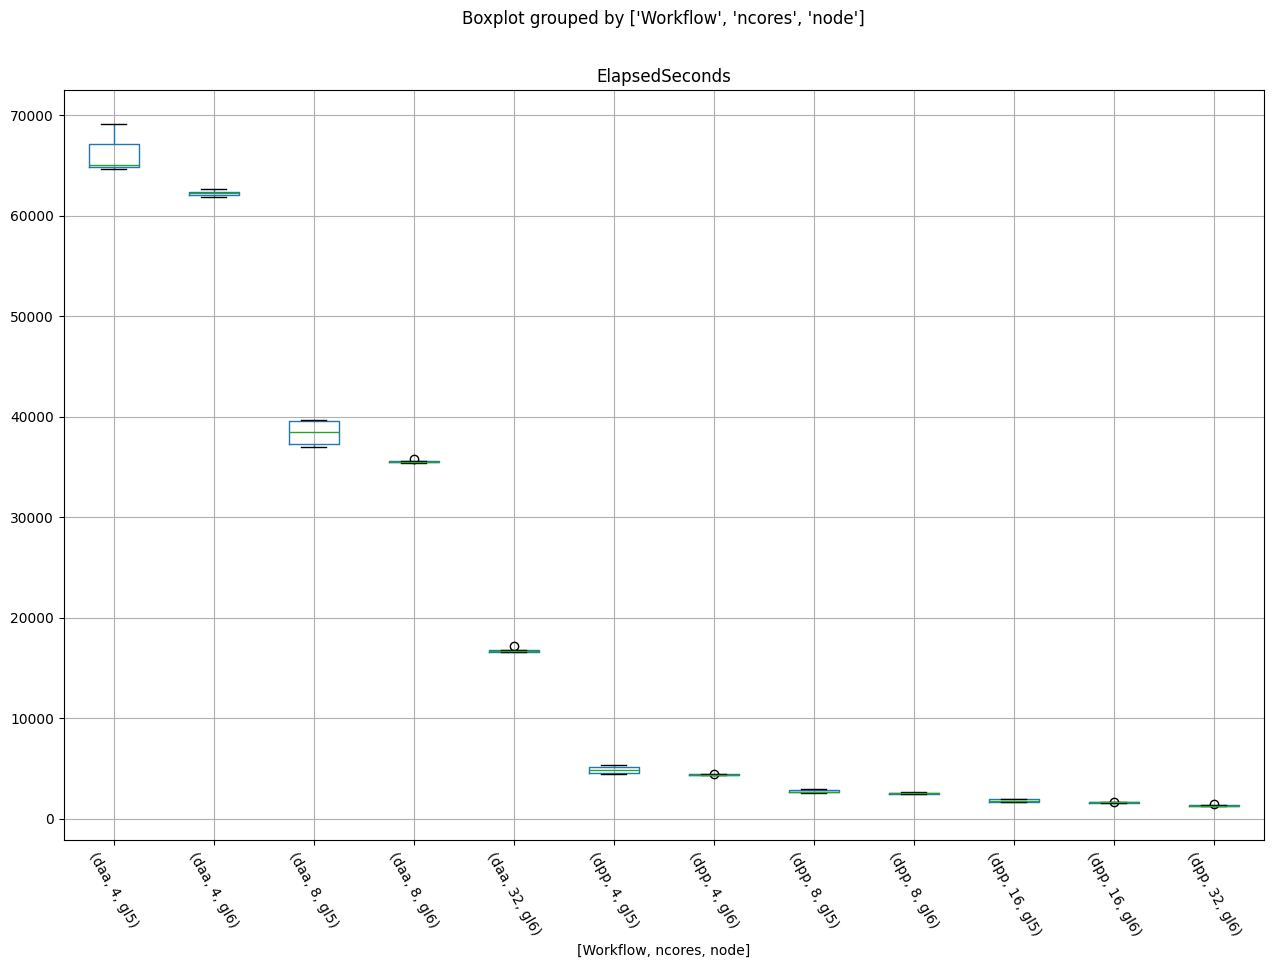

In [35]:
# draw one plot containing multiple boxplots with data distribution curve for each (workflow,ncores,node) agains EnergyConsumption
fig, ax = plt.subplots(figsize=(15, 10))
data_for_analysis.boxplot(column='ElapsedSeconds', by=['Workflow', 'ncores', 'node'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-60)
# save
fig.savefig('new.boxplot.png')


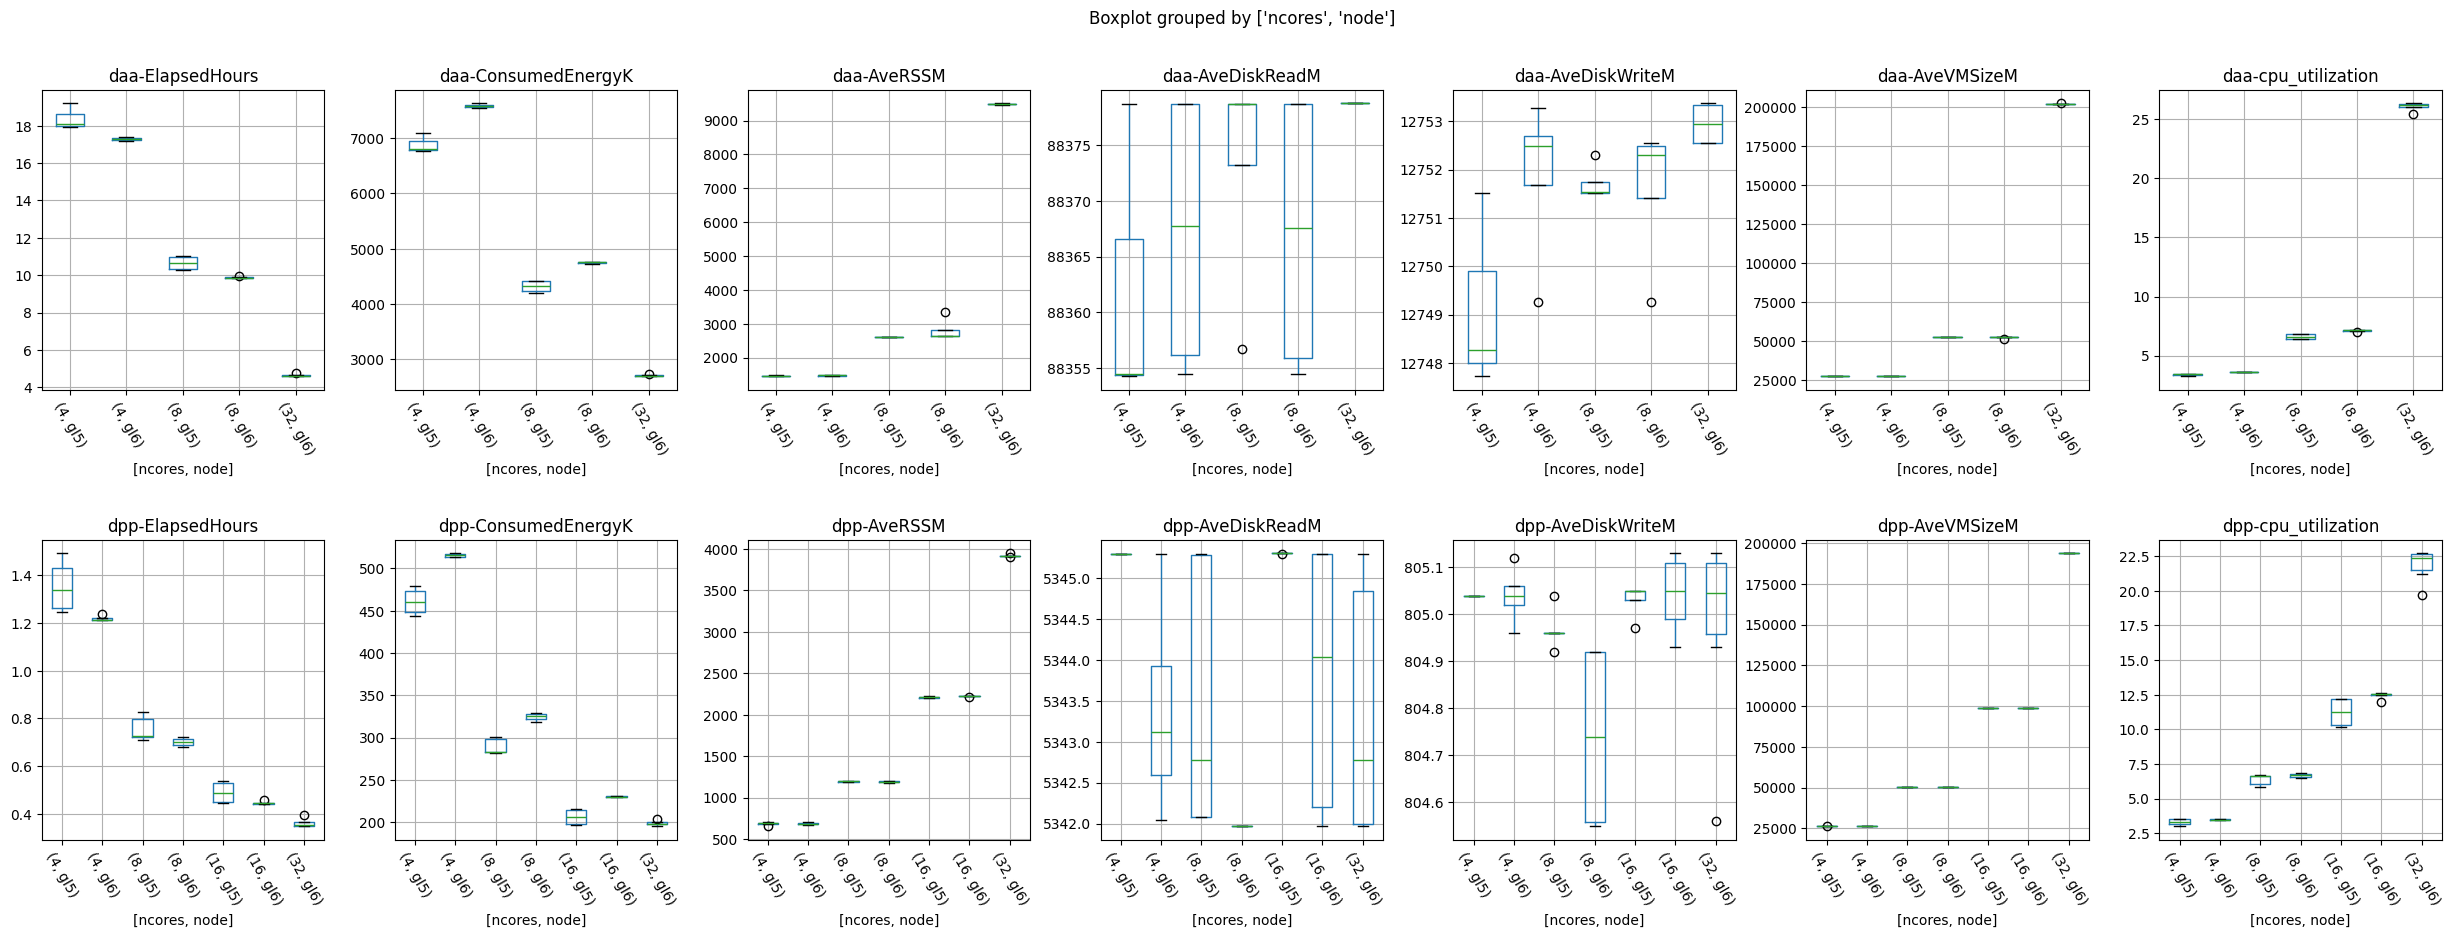

In [37]:
# draw two plots based on workflow containing multiple boxplots with data_for_analysis distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
for j, workflow in enumerate(data_for_analysis.Workflow.unique()):
    for i, column in enumerate(
            ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM',
             'cpu_utilization']):
        data_for_analysis[data_for_analysis.Workflow == workflow].boxplot(column=column, by=['ncores', 'node'],
                                                                          ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        ax[j, i].set_xticklabels(ax[j, i].get_xticklabels(), rotation=-60)
        # next to every boxplot box show data_for_analysis distribution

fig.subplots_adjust(hspace=0.5, wspace=0.25)

fig.savefig('new.boxplot-overview-by-workflows.png')

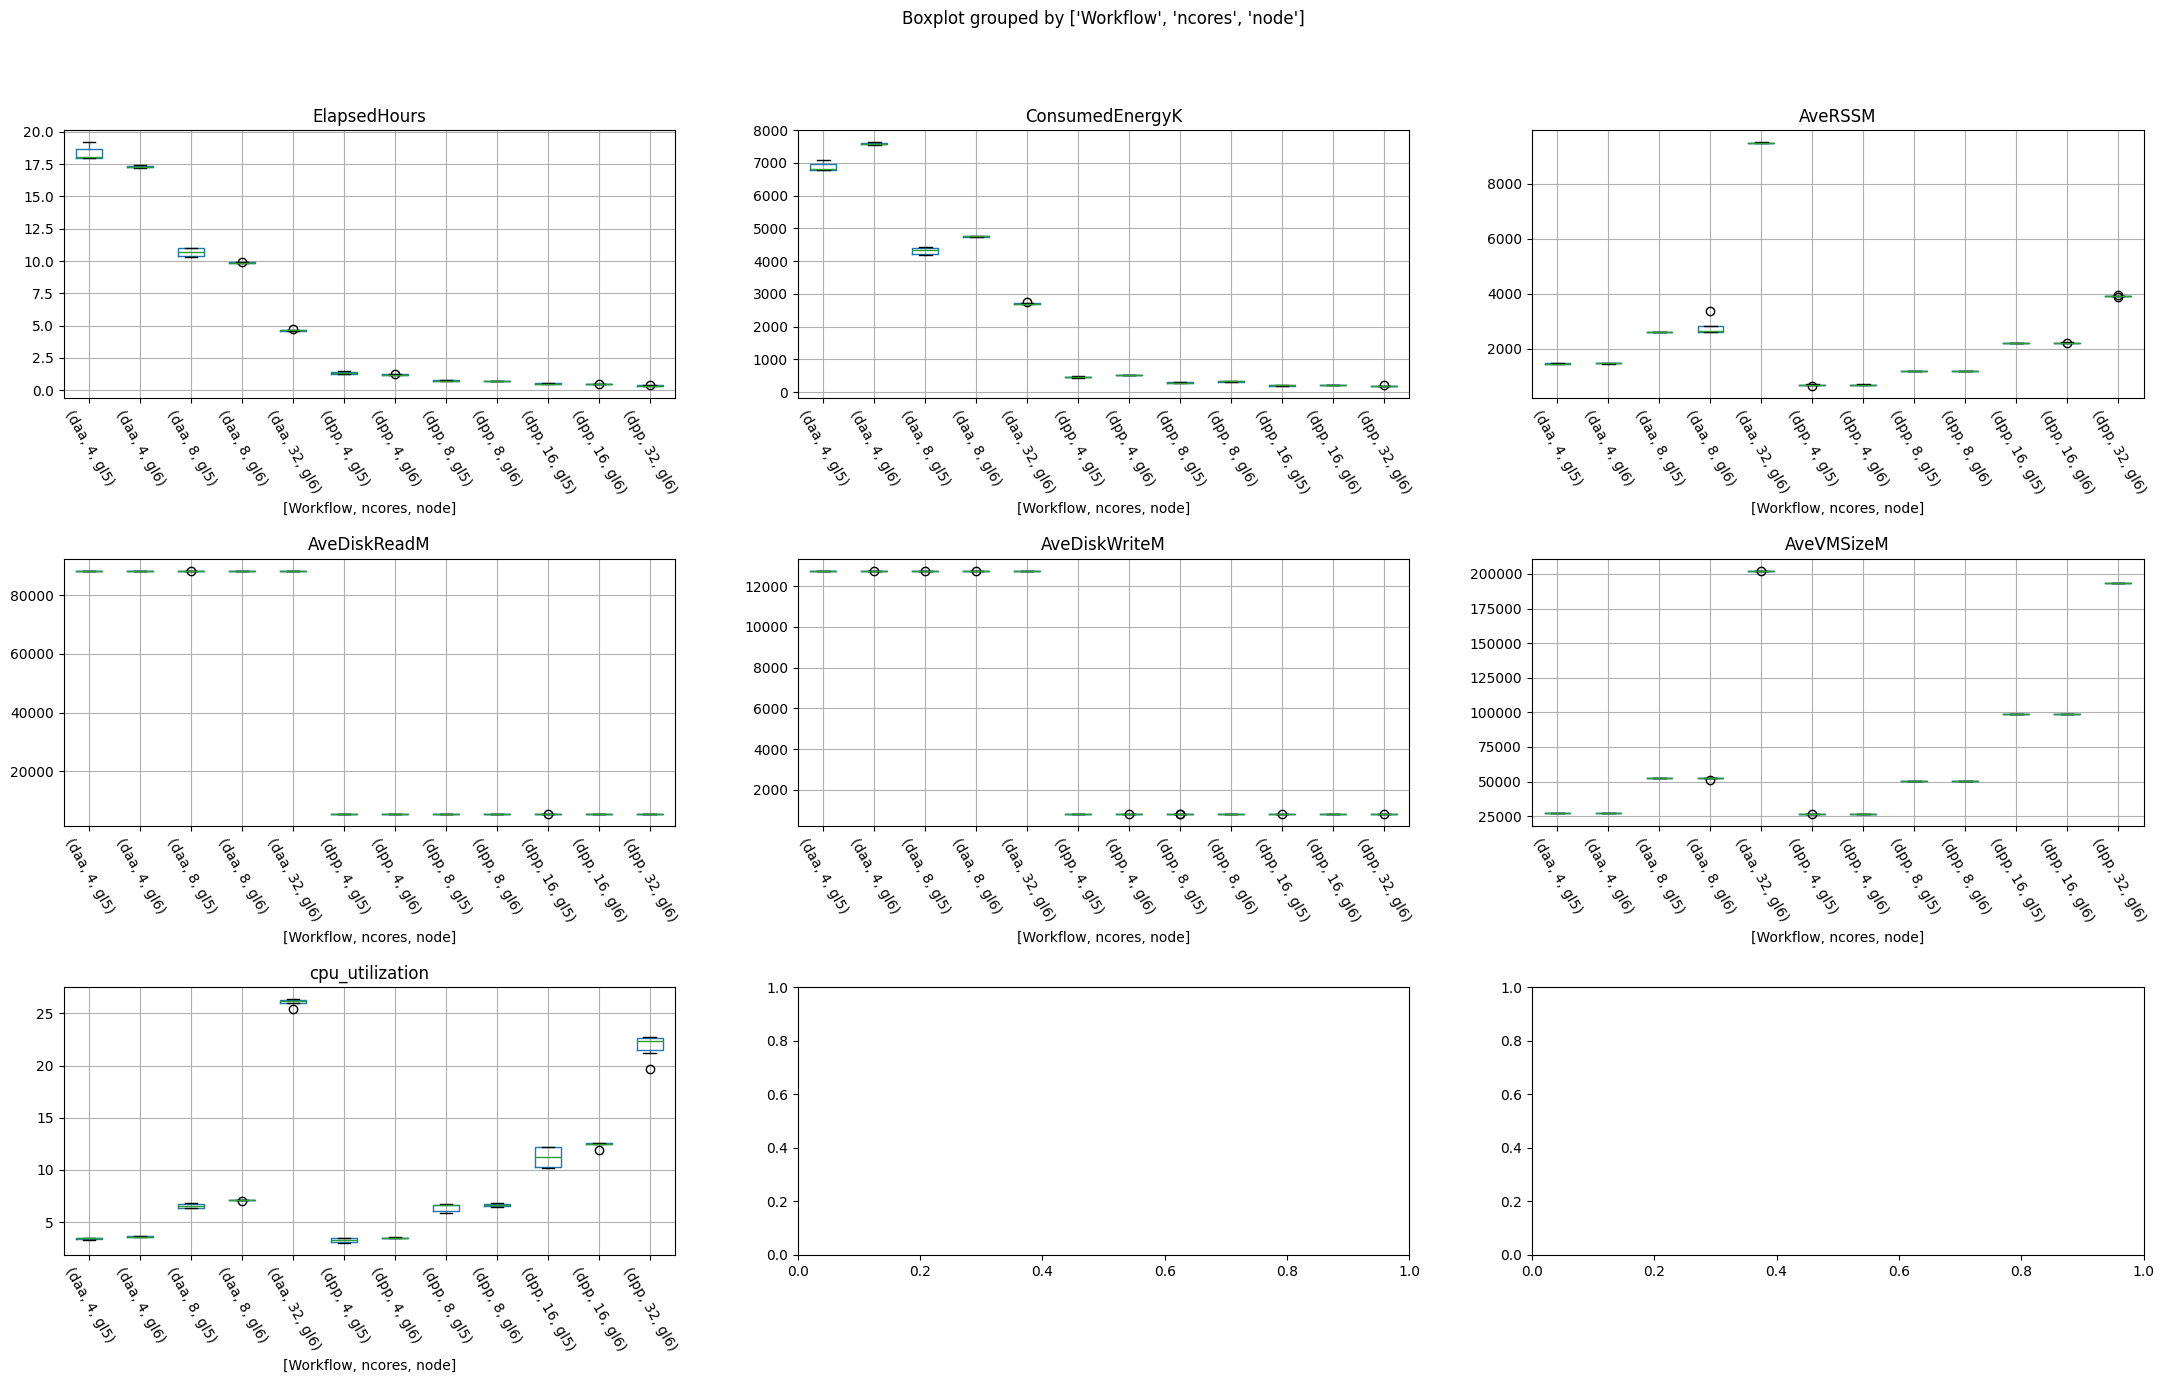

In [43]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(26, 15))
for i, column in enumerate(
        ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM',
         'cpu_utilization']):
    data_for_analysis.boxplot(column=column, by=['Workflow', 'ncores', 'node'], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)
    ax[i // 3, i % 3].set_xticklabels(ax[i // 3, i % 3].get_xticklabels(), rotation=-60)

fig.subplots_adjust(hspace=0.6)

fig.savefig('new.boxplot-overview.png')